<a href="https://colab.research.google.com/github/open-mmlab/mmsegmentation/blob/master/demo/MMSegmentation_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MMSegmentation Tutorial
Welcome to MMSegmentation! 

In this tutorial, we demo
* How to do inference with MMSeg trained weight
* How to train on your own dataset and visualize the results. 

## Install MMSegmentation
This step may take several minutes. 

We use PyTorch 1.5.0 and CUDA 10.1 for this tutorial. You may install other versions by change the version number in pip install command. 

In [1]:
# Check Pytorch installation
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMSegmentation installation
import mmseg
print(mmseg.__version__)

1.6.0 True
0.11.0


## Run Inference with MMSeg trained weight

In [5]:
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
from mmseg.core.evaluation import get_palette

In [7]:
config_file = '../local_configs/segformer/B0/segformer.b0.512x1024.city.160k.py'
checkpoint_file = '../checkpoint/trained_models/segformer.b0.512x1024.city.160k.pth'

In [8]:
# build the model from a config file and a checkpoint file
model = init_segmentor(config_file, checkpoint_file, device='cuda:0')

In [9]:
# test a single image
img = 'demo/demo.png'
result = inference_segmentor(model, img)

/content/mmsegmentation/mmseg/models/segmentors/base.py:265: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


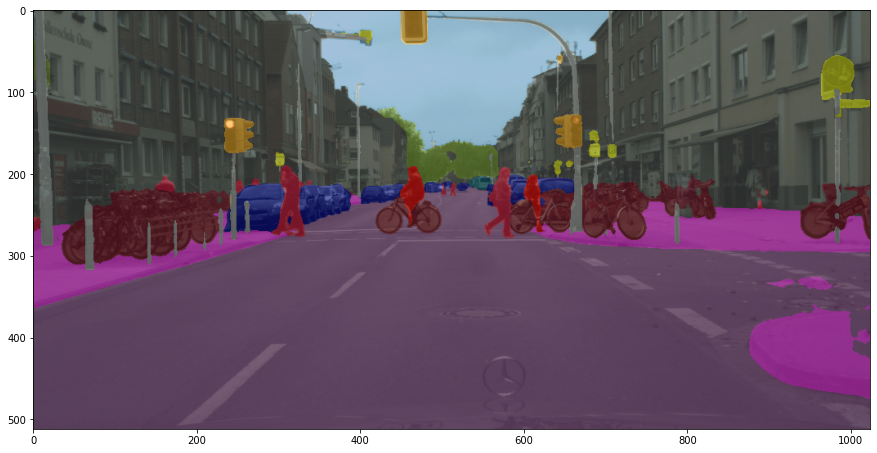

In [10]:
# show the results
show_result_pyplot(model, img, result, get_palette('cityscapes'))

## Train a semantic segmentation model on a new dataset

To train on a customized dataset, the following steps are neccessary. 
1. Add a new dataset class. 
2. Create a config file accordingly. 
3. Perform training and evaluation. 

### Add a new dataset

Datasets in MMSegmentation require image and semantic segmentation maps to be placed in folders with the same perfix. To support a new dataset, we may need to modify the original file structure. 

In this tutorial, we give an example of converting the dataset. You may refer to [docs](https://github.com/open-mmlab/mmsegmentation/docs/tutorials/new_dataset.md) for details about dataset reorganization. 

We use [Standord Background Dataset](http://dags.stanford.edu/projects/scenedataset.html) as an example. The dataset contains 715 images chosen from existing public datasets [LabelMe](http://labelme.csail.mit.edu), [MSRC](http://research.microsoft.com/en-us/projects/objectclassrecognition), [PASCAL VOC](http://pascallin.ecs.soton.ac.uk/challenges/VOC) and [Geometric Context](http://www.cs.illinois.edu/homes/dhoiem/). Images from these datasets are mainly outdoor scenes, each containing approximately 320-by-240 pixels. 
In this tutorial, we use the region annotations as labels. There are 8 classes in total, i.e. sky, tree, road, grass, water, building, mountain, and foreground object. 

In [1]:
# download and unzip
!wget http://dags.stanford.edu/data/iccv09Data.tar.gz -O standford_background.tar.gz
!tar xf standford_background.tar.gz

--2021-06-19 09:02:03--  http://dags.stanford.edu/data/iccv09Data.tar.gz
Resolving dags.stanford.edu (dags.stanford.edu)... 171.64.68.10
Connecting to dags.stanford.edu (dags.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14727974 (14M) [application/x-gzip]
Saving to: ‘standford_background.tar.gz’

standford_backgroun 100%[===================>]  14.04M  1.95MB/s    in 20s     

2021-06-19 09:02:23 (730 KB/s) - ‘standford_background.tar.gz’ saved [14727974/14727974]



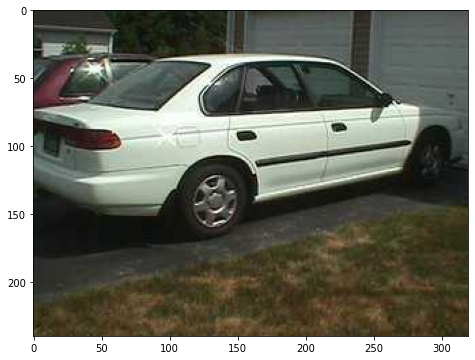

In [6]:
# Let's take a look at the dataset
import mmcv
import matplotlib.pyplot as plt

img = mmcv.imread('iccv09Data/images/0002755.jpg')
plt.figure(figsize=(8, 6))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

We need to convert the annotation into semantic map format as an image.

After downloading the data, we need to implement `load_annotations` function in the new dataset class `StandfordBackgroundDataset`.

In [ ]:
import os.path as osp
import numpy as np
from PIL import Image
# convert dataset annotation to semantic segmentation map
data_root = 'iccv09Data'
img_dir = 'images'
ann_dir = 'labels'
# define class and plaette for better visualization
classes = ('sky', 'tree', 'road', 'grass', 'water', 'bldg', 'mntn', 'fg obj')
palette = [[128, 128, 128], [129, 127, 38], [120, 69, 125], [53, 125, 34], 
           [0, 11, 123], [118, 20, 12], [122, 81, 25], [241, 134, 51]]

for file in mmcv.scandir(osp.join(data_root, ann_dir), suffix='.regions.txt'):
  seg_map = np.loadtxt(osp.join(data_root, ann_dir, file)).astype(np.uint8)
  seg_img = Image.fromarray(seg_map).convert('P')
  seg_img.putpalette(np.array(palette, dtype=np.uint8))
  seg_img.save(osp.join(data_root, ann_dir, file.replace('.regions.txt', '.png')))


In [ ]:
# Let's take a look at the segmentation map we got
import matplotlib.patches as mpatches
img = Image.open('iccv09Data/labels/0002755.png')
plt.figure(figsize=(8, 6))
im = plt.imshow(np.array(img.convert('RGB')))

# create a patch (proxy artist) for every color 
patches = [mpatches.Patch(color=np.array(palette[i])/255., 
                          label=classes[i]) for i in range(8)]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
           fontsize='large')

plt.show()

In [12]:
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset

@DATASETS.register_module()
class StandfordBackgroundDataset_test(CustomDataset):
  CLASSES = classes
  PALETTE = palette
  def __init__(self, split, **kwargs):
    super().__init__(img_suffix='.jpg', seg_map_suffix='.png', 
                     split=split, **kwargs)
    assert osp.exists(self.img_dir) and self.split is not None

    

### Train and Evaluation

Inference with trained model

### Single-gpu testing
!../tools/dist_train.sh /root/models/local_configs/custom_segformer/segformer-custom.b4.512x512.ade.160k.py 1